In [1]:
import boto3
from datetime import datetime, timedelta
import json
import matplotlib.pyplot as plt
import requests
import time

In [5]:
# NOTE: You will need to set AWS access keys for the MCP environment
# !env

In [2]:
%%time
client = boto3.client('logs', region_name='us-west-2')

query = """
fields @timestamp, @message
| filter @message like "cmr.search.api"
| filter @message like "Searching for granules"
| filter @message like "collection_concept_id"
| parse @message /collection_concept_id "(?<collection_concept_id>\S+)"/
| stats count(*) as number_queries by collection_concept_id
| sort by number_queries desc
"""

log_group = 'cmr-search-ops'
datetime_str = '05/18/22 00:00:00'
starting_datetime_object = datetime.strptime(datetime_str, '%m/%d/%y %H:%M:%S')

start_query_response = client.start_query(
    logGroupName=log_group,
    startTime=int(starting_datetime_object.timestamp()),
    endTime=int(datetime.now().timestamp()),
    queryString=query,
)

query_id = start_query_response['queryId']

logs_response = None

while logs_response == None or logs_response['status'] == 'Running':
    print('Waiting for query to complete ...')
    time.sleep(60)
    logs_response = client.get_query_results(
        queryId=query_id
    )

Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
CPU times: user 231 ms, sys: 46.9 ms, total: 278 ms
Wall time: 10min 2s


In [4]:
# Save the results so we don't have to re-run the query
filename = f"granules_collection_concept_id_search-{query_id}.json"
with open(filename, "w+") as f:
    f.write(json.dumps(logs_response))
    f.close()    

In [5]:
data = json.loads(open(filename).read())

In [6]:
restructured_data = []
limit = 25
for result in data['results']:
    entry_data = {}
    for entry in result:
        entry_data[entry['field']] = entry['value']
    restructured_data.append(entry_data)

restructured_data[0:limit]

[{'collection_concept_id': 'C1202028193-NASA_MAAP', 'number_queries': '48264'},
 {'collection_concept_id': 'C1201300747-NASA_MAAP', 'number_queries': '5964'},
 {'collection_concept_id': 'C1201746153-NASA_MAAP', 'number_queries': '3018'},
 {'collection_concept_id': 'C1201309827-NASA_MAAP', 'number_queries': '2704'},
 {'collection_concept_id': 'C1200110748-NASA_MAAP', 'number_queries': '110'},
 {'number_queries': '88'},
 {'collection_concept_id': 'C1201702030-NASA_MAAP', 'number_queries': '78'},
 {'collection_concept_id': 'C1200231010-NASA_MAAP', 'number_queries': '66'},
 {'collection_concept_id': 'C1201746156-NASA_MAAP', 'number_queries': '48'},
 {'collection_concept_id': 'C1201702032-NASA_MAAP', 'number_queries': '19'},
 {'collection_concept_id': 'C1200000308-NASA_MAAP', 'number_queries': '14'},
 {'collection_concept_id': 'C1200110729-NASA_MAAP', 'number_queries': '5'},
 {'collection_concept_id': 'C2237824918-ORNL_CLOUD', 'number_queries': '5'},
 {'collection_concept_id': 'C1200235747-

In [11]:
cmr_url = 'https://cmr.maap-project.org'
collections_search_url = f"{cmr_url}/search/collections.json"
results_dict = {}
for entry in restructured_data[0:limit]:
    # There's 1 blank concept_id entry
    if 'collection_concept_id' in entry:
        concept_id = entry['collection_concept_id']
        if concept_id.startswith('C'):
            cmr_response = requests.get(f"{collections_search_url}?concept_id={concept_id}")
        else:
            # Are we interested in granules searches? very limited results besides
            next
            #cmr_response = requests.get(f"{granules_search_url}?concept_id={concept_id}")
        number_queries = entry['number_queries']
        cmr_data = json.loads(cmr_response.text)['feed']['entry']
        if len(cmr_data) > 0:
            short_name = json.loads(cmr_response.text)['feed']['entry'][0]['short_name']
            results_dict[short_name] = int(number_queries)
        else:
            print(f"No entries found for {concept_id}")
    

No entries found for C2237824918-ORNL_CLOUD
No entries found for C2067521974-ORNL_CLOUD
No entries found for C2191500133-ORNL_CLOUD
No entries found for C1908348134-LPDAAC_ECS
No entries found for C2191500133-ORNL_CLOUD#


In [14]:
results_dict = {k: v for k, v in sorted(results_dict.items(), key=lambda item: item[1], reverse=True)}
results_dict

{'GEDI_L4A_AGB_Density_V2_1_2056': 48264,
 'ABLVIS1B': 110,
 'GEDI_L3_LandSurface_Metrics_V2_1952': 78,
 'SENTINEL-1A_DP_GRD_HIGH': 66,
 'GEDI02_A': 48,
 'GEDI_L4A_AGB_Density_V2_1986': 19,
 'AfriSAR_UAVSAR_Coreg_SLC': 14,
 'AFLVIS2': 5,
 'ATL08': 3,
 'ATL03': 1}

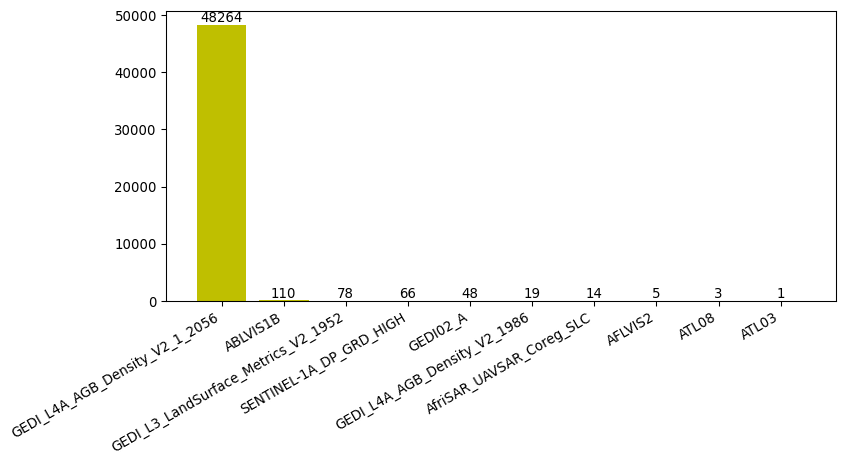

In [15]:
# data set
collections = list(results_dict.keys())
number_queries = list(results_dict.values())

plt.figure(figsize=(9, 4), dpi=96)

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center', va= 'bottom')

plt.bar(collections, number_queries, color='y')
addlabels(collections, number_queries)
plt.xticks(rotation=30, ha='right')
plt.show()